See instructions posted on Canvas under [Problem Sets](https://canvas.wisc.edu/courses/288496/files/folder/problem_sets).

Suggested imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Turn on interactive plotting

In [2]:
%matplotlib notebook

## Vector Operations

In [3]:
def dotProduct(a, b):
    sum = 0
    for n in range(3):
        sum += a[n] * b[n]
    return sum

In [4]:
a = (1, 0, 0)
b = (0, 2, 0)
c = (3, 0, 0)
assert np.dot(a, b) == dotProduct(a, b)
assert np.dot(b, a) == dotProduct(b, a)
assert np.dot(a, c) == dotProduct(a, c)

In [5]:
def crossProduct(a, b):
    return (a[1] * b[2] - a[2] * b[1],
            -(a[0] * b[2] - a[2] * b[0]),
            a[0] * b[1] - a[1] * b[0])

In [6]:
a = (1, 0, 0)
b = (0, 2, 0)
c = (3, 0, 0)
assert np.all(np.cross(a, b) == crossProduct(a, b))
assert np.all(np.cross(b, a) == crossProduct(b, a))
assert np.all(np.cross(a, c) == crossProduct(a, c))

In [7]:
def angleBetween(a, b):
    cosAngle = np.dot(a, b) / (magnitude(a) * magnitude(b))
    return np.arccos(cosAngle)

# computes the magnitude of vector a
def magnitude(a):
    squareSum = 0
    for x in a:
        squareSum += x*x
    return np.sqrt(squareSum)

In [8]:
a = (1, 0, 0)
b = (0, 2, 0)
c = (3, 0, 0)
assert angleBetween(a, b) == np.pi / 2.
assert angleBetween(b, a) == np.pi / 2.
assert angleBetween(b, c) == np.pi / 2.
assert angleBetween(a, c) == 0.

## Projectile with Quadratic Air Resistance

### Helper functions
The motion of a projectile traveling under the effect of gravity and quadratic air resistence is described by the following system of differential equations:
$$m\dot{v_{x}}=-c\sqrt{v_{x}^2+v_{y}^2}v_{x}$$<br />
$$m\dot{v_{y}}=-mg-c\sqrt{v_{x}^2+v_{y}^2}v_{y}$$<br />
and $c = γD^2$ is the quadratic drag coefficient, where $γ=0.25Ns^4m^{−4}$ and $D$ is the diameter of the object. 

<br />We have the relations: 
$$\frac{dv_{x}}{dt}=\dot{v_{x}}$$<br />
$$\frac{dv_{y}}{dt}=\dot{v_{y}}$$<br />
where $x,y$ represents the horizontal and vertical position of the projectile relative to its initial position.<br /><br />
Re-arranging the equations, we have:
$$\frac{dx}{dt}=\dot{x}$$<br />
$$\frac{dy}{dt}=\dot{y}$$<br />
$$\frac{dv_{x}}{dt}=-\frac{c}{m}\sqrt{\dot{x}^2+\dot{y}^2}\dot{x}$$<br />
$$\frac{dv_{y}}{dt}=-g-\frac{c}{m}\sqrt{\dot{x}^2+\dot{y}^2}\dot{y}$$<br />

```projectile(t, w, d, m, g)``` returns the right hand side of this system of equations and is used as the ```fun``` parameter of ```solve_ivp```to solve the system of differential equations

In [9]:
# represent the system of differential equations
def projectile(t, w, d, m, g):
    
    # position(m), horizontal and vertical velocity(m/s)
    x, xdot, y, ydot = w
    
    # drag coefficient
    c = 0.25 * d**2
    
    speed = np.hypot(xdot, ydot)
    # acceleration on the x and y direction
    xdotdot = -c/m * speed * xdot
    ydotdot = -c/m * speed * ydot - g
    
    return xdot, xdotdot, ydot, ydotdot

# event function, trigered when object hits the ground
def hit_ground(t, w): return w[2]
# stop integration when object hits the ground
hit_ground.terminal = True
# only triger event when object hits ground from above the ground...
hit_ground.direction = -1

def max_height(t, w): return w[3]

# set initial conditions:
def set_initial(v_0, theta):
    x_0 = 0.
    y_0 = 0.
    xdot_0 = v_0 * np.cos(theta)
    ydot_0 = v_0 * np.sin(theta)
    return x_0, xdot_0, y_0, ydot_0


### guess Fucntion

```guess(distance, d, m, g, t_min, t_max)```

Given the horizontal distance traveled by a projectile, estimate the trajectory and initial velocity of the projectile under the effect of quadratic air resistence.

First, it finds the minimum initial speed to reach the specified horizonral distance at 45˚ lauching angle. Then, with this initial speed, it tries angles between 38˚ and 45˚ to find a launching angle where the horizontal distance traveled is the largest.


In [10]:
def guess(distance, d, m, g, t_min, t_max):
    
    # VACUUM: optimal launch angle, initial speed, inital conditions, constants
    theta_vacuum = 45
    v0_vacuum = np.sqrt(g * distance)
    w0_vacuum = set_initial(v0_vacuum, np.radians(theta_vacuum))
    constants_vacuum = 0, m, g # the particle is in vacuum when it has no diameter
    
    # projectile in vacuum
    sol_vacuum = solve_ivp(lambda t, w: projectile(t, w, *constants_vacuum),
                           (t_min, t_max),
                           w0_vacuum,
                           dense_output=True,
                           events=(hit_ground, max_height))
    
    # AIR: first guess launch angle, initial speed, initial conditions, 
    # constants, horizontal distance given the initial conditions
    theta_air = theta_vacuum
    v0_air = v0_vacuum
    w0_air = set_initial(v0_air, np.radians(theta_air))
    constants_air = d, m, g
    actual_distance = 0
    
    # projectile in air, considering only quadratic drag force
    sol_air = []
    
    # solve the motion equation based on each increase of initial speed
    # until reaching the targeted horizontal distance
    while True:
        sol = solve_ivp(lambda t, w: projectile(t, w, *constants_air),
                       (t_min, t_max),
                       w0_air,
                       dense_output=True,
                       events=(hit_ground, max_height))
        actual_distance = sol.y[0][-1]
        # stop loop when target distance is reached
        if actual_distance >= distance: 
            sol_air = sol
            break
        v0_air += 0.01
        w0_air = set_initial(v0_air, np.radians(theta_air))

    # guessed best launch angle
    best_theta = 45.0
    # find a launch angle that results in a further horizontal distance than 45˚ does
    for theta in np.arange(38.0, 45.0, 0.1):
        w0_air = set_initial(v0_air, np.radians(theta))
        sol = solve_ivp(lambda t, w: projectile(t, w, *constants_air),
                        (t_min, t_max),
                        w0_air,
                        dense_output=True,
                        events=(hit_ground, max_height))
        this_actual_distance = sol.y[0][-1]
        print("theta: %5.2f => distance: %5.2f " % (theta, this_actual_distance))
        # found the current best optimal launch angle
        if this_actual_distance > actual_distance:
            sol_air = sol
            best_theta = theta
            actual_distance = this_actual_distance
    print("distance traveled: %5.2f" % actual_distance)
    return sol_vacuum, sol_air, v0_air, best_theta, v0_vacuum
    

### a) Ryan Crouser's Shot
Based on the calculation below, the initial velocity of the shot has the magnitude of $15.18m/s$ and the direction of $44.9˚$ above the ground level.

theta: 38.00 => distance: 22.69 
theta: 38.10 => distance: 22.71 
theta: 38.20 => distance: 22.73 
theta: 38.30 => distance: 22.75 
theta: 38.40 => distance: 22.77 
theta: 38.50 => distance: 22.79 
theta: 38.60 => distance: 22.81 
theta: 38.70 => distance: 22.82 
theta: 38.80 => distance: 22.84 
theta: 38.90 => distance: 22.86 
theta: 39.00 => distance: 22.87 
theta: 39.10 => distance: 22.89 
theta: 39.20 => distance: 22.91 
theta: 39.30 => distance: 22.92 
theta: 39.40 => distance: 22.94 
theta: 39.50 => distance: 22.96 
theta: 39.60 => distance: 22.97 
theta: 39.70 => distance: 22.99 
theta: 39.80 => distance: 23.00 
theta: 39.90 => distance: 23.01 
theta: 40.00 => distance: 23.03 
theta: 40.10 => distance: 23.04 
theta: 40.20 => distance: 23.06 
theta: 40.30 => distance: 23.07 
theta: 40.40 => distance: 23.08 
theta: 40.50 => distance: 23.09 
theta: 40.60 => distance: 23.11 
theta: 40.70 => distance: 23.12 
theta: 40.80 => distance: 23.13 
theta: 40.90 => distance: 23.14 
theta: 41.

<IPython.core.display.Javascript object>


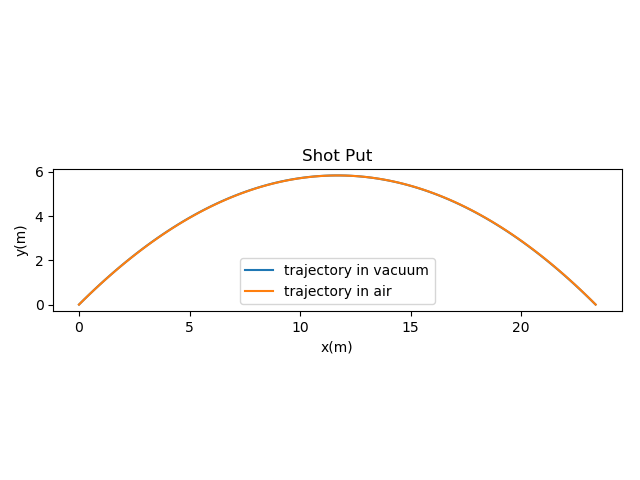

In [11]:
# Ryan Crouser Shot
results_a = guess(23.37, 0.1, 7.26, 9.8, 0, 50)
soln1_vacuum = results_a[0]
soln1_air = results_a[1]
t1_vacuum = np.linspace(0, soln1_vacuum.t_events[0][0], 100)
t1_air = np.linspace(0, soln1_air.t_events[0][0], 100)
sol1_vacuum = soln1_vacuum.sol(t1_vacuum)
sol1_air = soln1_air.sol(t1_air)
v0a_air = results_a[2]
v0a_vacuum = results_a[4]
theta_a = results_a[3]
print("initial speed in vacuum: %5.2f" %v0a_vacuum)
print("initial speed in air: %5.2f" %v0a_air)
print("theta: %5.2f" % theta_a)

plt.figure()
plt.gca().set_aspect(1)
plt.plot(sol1_vacuum[0], sol1_vacuum[2], label='trajectory in vacuum')
plt.plot(sol1_air[0], sol1_air[2], label='trajectory in air')
plt.title('Shot Put')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.tight_layout()

### b) Milwaukee Brewers Baseball Homerun
Based on the calculation below, the initial velocity to make a homerun has the magnitude of $46.12m/s$ and the direction of $39.20˚$ above the ground level.

theta: 38.00 => distance: 101.44 
theta: 38.10 => distance: 101.45 
theta: 38.20 => distance: 101.46 
theta: 38.30 => distance: 101.47 
theta: 38.40 => distance: 101.48 
theta: 38.50 => distance: 101.49 
theta: 38.60 => distance: 101.49 
theta: 38.70 => distance: 101.50 
theta: 38.80 => distance: 101.50 
theta: 38.90 => distance: 101.50 
theta: 39.00 => distance: 101.51 
theta: 39.10 => distance: 101.51 
theta: 39.20 => distance: 101.51 
theta: 39.30 => distance: 101.51 
theta: 39.40 => distance: 101.51 
theta: 39.50 => distance: 101.50 
theta: 39.60 => distance: 101.50 
theta: 39.70 => distance: 101.50 
theta: 39.80 => distance: 101.49 
theta: 39.90 => distance: 101.49 
theta: 40.00 => distance: 101.48 
theta: 40.10 => distance: 101.47 
theta: 40.20 => distance: 101.46 
theta: 40.30 => distance: 101.45 
theta: 40.40 => distance: 101.44 
theta: 40.50 => distance: 101.43 
theta: 40.60 => distance: 101.42 
theta: 40.70 => distance: 101.41 
theta: 40.80 => distance: 101.39 
theta: 40.90 =

<IPython.core.display.Javascript object>


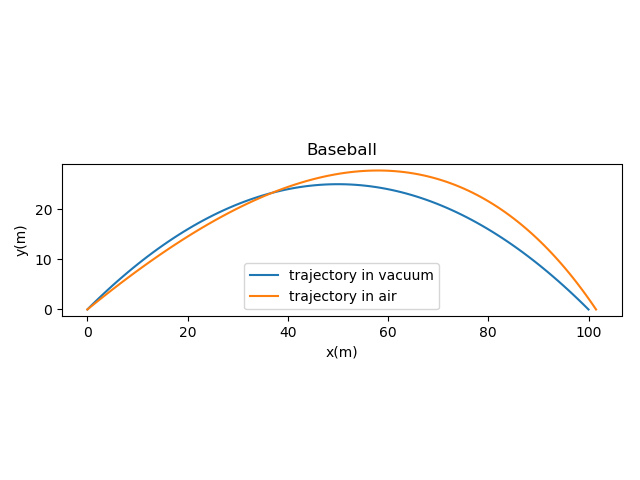

In [12]:
# Milwaukee Brewers Baseball
results_b = guess(100, 0.07, 0.15, 9.8, 0, 50)
soln2_vacuum = results_b[0]
soln2_air = results_b[1]
t2_vacuum = np.linspace(0, soln2_vacuum.t_events[0][0], 100)
t2_air = np.linspace(0, soln2_air.t_events[0][0], 100)
sol2_vacuum = soln2_vacuum.sol(t2_vacuum)
sol2_air = soln2_air.sol(t2_air)
v0b_air = results_b[2]
theta_b = results_b[3]
print("initial speed: %5.2f" %v0b_air)
print("theta: %5.2f" % theta_b)

plt.figure()
plt.gca().set_aspect(1)
plt.plot(sol2_vacuum[0], sol2_vacuum[2], label='trajectory in vacuum')
plt.plot(sol2_air[0], sol2_air[2], label='trajectory in air')
plt.title('Baseball')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.tight_layout()

### c) Comparison plots

#### Ryan Crouser's Shot
Compair the trajectory of Ryan Crouser's Shot with and without air resistence given the following initial velocity:<br />
Initial Speed: 15.18 m/s <br />
Launch Angle: 45˚<br />

<IPython.core.display.Javascript object>


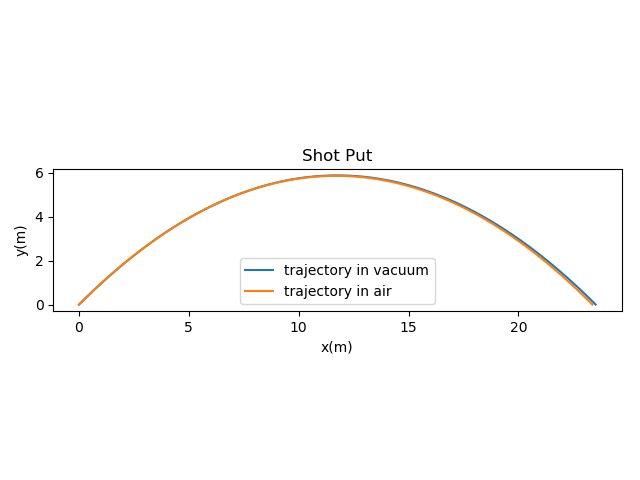

In [13]:
w0_a = set_initial(15.18, np.radians(45))
constants_vacuum_ryan = 0, 7.26, 9.8 
constants_air_ryan = 0.1, 7.26, 9.8 

    
# projectile in vacuum
soln_vacuum_a = solve_ivp(lambda t, w: projectile(t, w, *constants_vacuum_ryan),
                         (0, 50),
                         w0_a,
                         dense_output=True,
                         events=(hit_ground, max_height))
soln_air_a = solve_ivp(lambda t, w: projectile(t, w, *constants_air_ryan),
                       (0, 50),
                       w0_a,
                       dense_output=True,
                       events=(hit_ground, max_height))

t_vacuum_a = np.linspace(0, soln_vacuum_a.t_events[0][0], 100)
sol_vacuum_a = soln_vacuum_a.sol(t_vacuum_a)
t_air_a = np.linspace(0, soln_air_a.t_events[0][0], 100)
sol_air_a = soln_air_a.sol(t_air_a)

plt.figure()
plt.gca().set_aspect(1)
plt.plot(sol_vacuum_a[0], sol_vacuum_a[2], label='trajectory in vacuum')
plt.plot(sol_air_a[0], sol_air_a[2], label='trajectory in air')
plt.title('Shot Put')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.tight_layout()

#### Milwaukee Brewers Baseball Homerun
Compair the trajectory of Milwaukee Brewers's baseball with and without air resistence given the following initial velocity:<br />
Initial Speed: 46.12 m/s <br />
Launch Angle: 45˚<br />

<IPython.core.display.Javascript object>


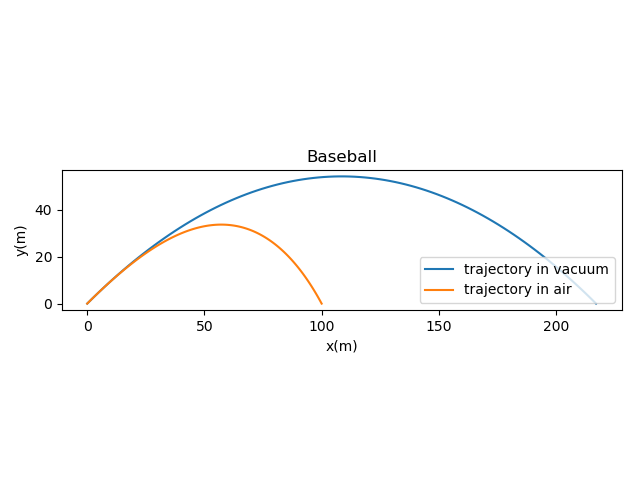

In [14]:
w0_b = set_initial(46.12, np.radians(45))
constants_vacuum_mil = 0, 0.15, 9.8 
constants_air_mil = 0.07, 0.15, 9.8 

    
# projectile in vacuum
soln_vacuum_b = solve_ivp(lambda t, w: projectile(t, w, *constants_vacuum_mil),
                         (0, 50),
                         w0_b,
                         dense_output=True,
                         events=(hit_ground, max_height))
soln_air_b = solve_ivp(lambda t, w: projectile(t, w, *constants_air_mil),
                       (0, 50),
                       w0_b,
                       dense_output=True,
                       events=(hit_ground, max_height))

t_vacuum_b = np.linspace(0, soln_vacuum_b.t_events[0][0], 100)
sol_vacuum_b = soln_vacuum_b.sol(t_vacuum_b)
t_air_b = np.linspace(0, soln_air_b.t_events[0][0], 100)
sol_air_b = soln_air_b.sol(t_air_b)

plt.figure()
plt.gca().set_aspect(1)
plt.plot(sol_vacuum_b[0], sol_vacuum_b[2], label='trajectory in vacuum')
plt.plot(sol_air_b[0], sol_air_b[2], label='trajectory in air')
plt.title('Baseball')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.legend()
plt.tight_layout()

## Charged Particle in Electric and Magnetic Fields

The electromagnetic force experienced by the particle is given by the Lorentz force law:
 
$$
\begin{align*}
\overrightarrow{F}&=q(\overrightarrow{E}+\overrightarrow{v}\times\overrightarrow{B})\\
&= q\overrightarrow{E}+q(\overrightarrow{v}\times\overrightarrow{B}) \tag{1}\\
\end{align*}
$$<br>

 ### a)

Given 

$$
\begin{align*}
\overrightarrow{v} &= (v_x,0,0)\\
\overrightarrow{B} &= (0,0,B)\\
\overrightarrow{E} &= (0, E, 0)
\end{align*}
$$

Substituting into $(1)$ we have 

$$
\begin{align*}
\overrightarrow{F} = (0, qE-qBv_x,0) \tag{2}\\  
\end{align*}
$$

From $(2)$ we have

$$
\begin{align*}
\overrightarrow{F}_x&=0\\
\overrightarrow{F}_y&=qE-qBv_x\\
\overrightarrow{F}_z&=0\\
\end{align*}
$$

We see that the $z$ component of the electromagnetic force $\overrightarrow{F}_z$ is $0$. Thus, the particle experience no acceleration along the $z$ axis, and its motion will remain on the plane $z=0$

### b)
For the particle to move undeflected through the field, it must experience zero force in the direction perpendicular to its motion. Thus, we have the following:

$$
\begin{align}
\overrightarrow{F}_y&=qE-qBv_{x0} = 0\\
\end{align}
$$

Solving for $v_{x0}$ yields a unique solution:

$$
v_{dr}=v_{x0} = \frac{E}{B}
$$

Thus, there is a unique value of $v_{x0}=\frac{E}{B}$, called the drift velocity $v_{dr}$, for which the particle moves undeflected through the fields.

### c)
With $(1)$, decomposing $\overrightarrow{v}$ into velocities on the $\hat{x}, \hat{y}$ directions $\overrightarrow{v_x}, \overrightarrow{v_y}$ yields:

$$
\begin{align*}
\overrightarrow{F_{x}} &= q\overrightarrow{E_x}+q(\overrightarrow{v_y}\times\overrightarrow{B})\\
\overrightarrow{F_{y}} &= q\overrightarrow{E_y}+q(\overrightarrow{v_x}\times\overrightarrow{B})\\\tag{3}
\end{align*}
$$

Since $\overrightarrow{E}=(0, E, 0)$, we have:

$$
\begin{align*}
F_{x}&=qv_yB\\
F_{y}&=qE-qv_xB\\
\end{align*}
$$

and

$$
\begin{align*}
\dot{v_x}&=\frac{qB}{m}v_y\\
\dot{v_y}&=\frac{qE}{m}-\frac{qB}{m}v_x\\
\end{align*}
$$

With $v_{dr}=\frac{E}{B}$, we have $\frac{qE}{m}-\frac{qB}{m}v_{dr}=\frac{qE}{m}-\frac{qE}{m}=0$. Thus, we can perform the following operation:

$$
\begin{align*}
\dot{v_y}-0&=(\frac{qE}{m}-\frac{qB}{m}v_x)-(\frac{qE}{m}-\frac{qB}{m}v_{dr})\\\\
\dot{v_y}-0&=-\frac{qB}{m}(v_x-v_{dr})
\end{align*}
$$

Letting $u_x=v_x-v_{dr}$ and $u_y=v_y-0$, and defining the cyclotron frequency as $\omega = \frac{qB}{m}$ yields:

$$
\begin{align*}
\dot{u_y}&=\dot{v_y}=-\omega u_x\\
\dot{u_x}&=\dot{v_x}= \omega u_y\\
\end{align*}
$$

Taking the derivative of $\dot{u_x}$ we get

$$
\ddot{u}_x=\omega\dot{u}_y=-\omega^2u_x
$$

The general solution for this second-order differential equation is:

$$
\begin{align*}
u_x&=A\sin{\omega t}+B\cos{\omega t}\tag{4}\\
\end{align*}
$$ 

Substituting $(4)$ into $\dot{u}_x=\omega u_y$ we get:

$$
\begin{align*}
\omega u_y&=\dot{u}_x=\omega A\cos{\omega t} - \omega B\sin{\omega t}\\
u_y&=A\cos{\omega t}-B\sin{\omega t}\tag{5}
\end{align*}
$$

With 

$$
\begin{align*}
u_x(0)&=v_x(0)-v_{dr}=v_{x0}-v_{dr}\\
u_y(0)&=v_y(0)=0
\end{align*}
$$

we can solve for $A$:

$$
\begin{align*}
u_y(0)&=v_y(0)=A\cos{0} - B\sin{0}\\
A&=0
\end{align*}
$$

and $B$:

$$
\begin{align*}
u_x(0)&=v_x(0)-v_{dr}=A\sin{0}+B\cos{0}\\
B&=v_{x0}-v_{dr}\\
\end{align*}
$$

With $u_x(t)=v_x(t)-v_{dr}$ and $u_y(t)=v_y(t)$ and substituting $A$, $B$ into $(4)$ and $(5)$, we have the particle's velocity as a function of $t$:

$$
\begin{align*}
v_x(t)&=v_{dr}+(v_{x0}-v_{dr})\cos{\omega t}\\
v_y(t)&=-(v_{x0}-v_{dr})\sin{\omega t}
\end{align*}
$$


### d)
Integrating $v_x(t')$ and $v_y(t')$ over $0$ to $t$:

$$
\begin{align*}
x(t)&=\int_0^tv_x(t')dt'\\
&=\int_0^tv_{dr}dt'+(v_{x0}-v_{dr})\int_0^t\cos{(\omega t')}dt'\\
&=(v_{dr}t-0)+(v_{x0}-v_{dr})[\frac{1}{w}\sin{(\omega t)}-\frac{1}{w}\sin{(0)}]\\
&=v_{dr}t+R\sin{(\omega t)}\\\\
y(t)&=\int_0^tv_y(t')dt'\\
&=\int_0^t -(v_{x0}-v_{dr})\sin{(\omega t')}dt'\\
&=-(v_{x0}-v_{dr})\int_0^t -\sin{(\omega t')}dt'\\
&=(v_{x0}-v_{dr})\frac{1}{\omega}[\cos{(\omega t)}-\cos{(0)}]\\
&=R[\cos{(\omega t)} - 1]
\end{align*}
$$
where $R=\frac{v_{x0}-v_{dr}}{\omega}$.


In [15]:
# as per the peoblem set instruction, we define v_dr and omega to be 1 and 1
v_dr, omega = 1, 1
t_start, t_end = 0, 6 * np.pi / omega
t_array = np.linspace(t_start, t_end, 1000)

# computes the x, y position of the particle as a function of t
# returns a tuple (x, y)
def position(t, v_x0):
    
    R = (v_x0 - v_dr)/omega
    
    x_t = v_dr * t + R * np.sin(omega * t)
    y_t = R * (np.cos(omega * t) - 1)
    
    return x_t, y_t

#### The trajectory of particle if placed in the field with initial velocity $(v_{dr},0,0)$

<IPython.core.display.Javascript object>


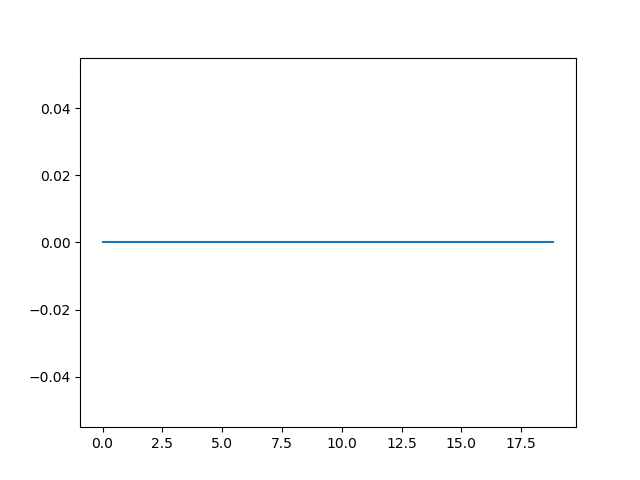

In [16]:
positions = list(map(lambda t: position(t, 1), 
                     t_array))

x_t = list(map(lambda p: p[0],
               positions))
y_t = list(map(lambda p: p[1],
               positions))

plt.figure()
plt.plot(x_t, y_t)


#### The trajectory of particle if placed in the field with initial velocity $(0,0,0)$


<IPython.core.display.Javascript object>


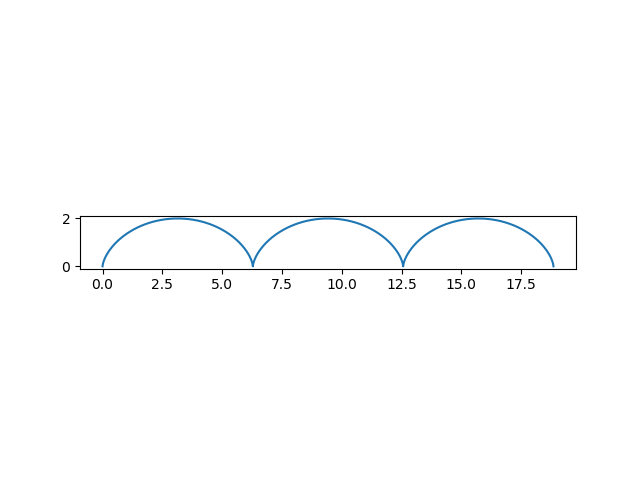

In [17]:
positions = list(map(lambda t: position(t, 0), 
                     t_array))

x_t = list(map(lambda p: p[0],
               positions))
y_t = list(map(lambda p: p[1],
               positions))

plt.figure()
plt.gca().set_aspect(1)
plt.plot(x_t, y_t)

#### The trajectory of particle if placed in the field with initial velocity $(-v_{dr},0,0)$

<IPython.core.display.Javascript object>


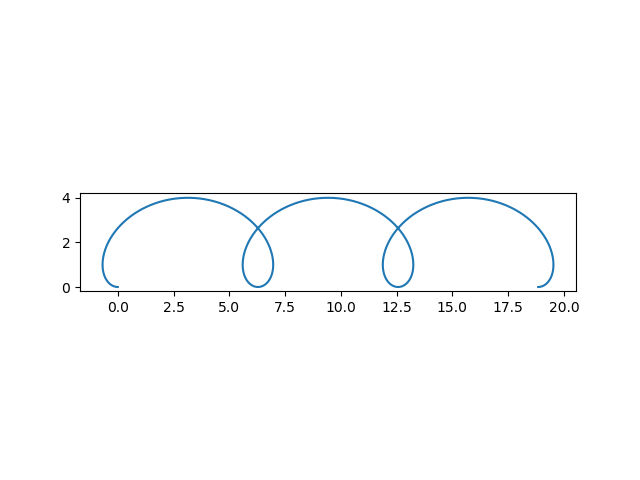

In [18]:
positions = list(map(lambda t: position(t, -1), 
                     t_array))

x_t = list(map(lambda p: p[0],
               positions))
y_t = list(map(lambda p: p[1],
               positions))

plt.figure()
plt.gca().set_aspect(1)
plt.plot(x_t, y_t)